What is dimensionality reduction?

What makes this "unsupervised learning" ?

What consittiutes high-dimensional data?
 - not arrays with large ndim!
 - 2D arrays with many columns
 - each row is a vector in an ND space

Examples
  - neurons vs features
  - time steps vs neurons
  - neurons vs time steps

Further reading: https://scikit-learn.org/stable/unsupervised_learning.html

In [54]:
import sklearn.datasets
# dataset = sklearn.datasets.fetch_california_housing()
dataset = sklearn.datasets.load_iris()
# dataset = sklearn.datasets.load_wine()
data = dataset['data']
target = dataset['target']
print(data.shape)

print(dataset['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Let's make a fake dataset consisting of 1000 samples, each described by 20 features. 

We could imagine this is, for example, a description of 1000 neurons, where each neuron is desctibed by features like "average firing rate", "width of cell body", "number of input synapses", etc.

In [158]:
data, target = sklearn.datasets.make_classification(
    n_samples=1000,
    n_features=20,
    n_classes=4, 
    n_clusters_per_class=1,
    class_sep=2,
    n_informative=10,
    random_state=4,
)
print("Data shape:", data.shape)

Data shape: (1000, 20)


Each neuron is described by a vector of length 20, and thus the space of all possible descriptions is 20-dimensional. 

But we suspect that the neurons to not uniformly fill this space, that there is some structure to the data -- for example, some features may be correlated with each other, or perhaps the neurons form distinct clusters within this space.

So the goal of unsupervised machine learning is to ask whether we can automatically generate a simpler description of the data. How much of the interesting structure can we explain using a much smaller number of features?

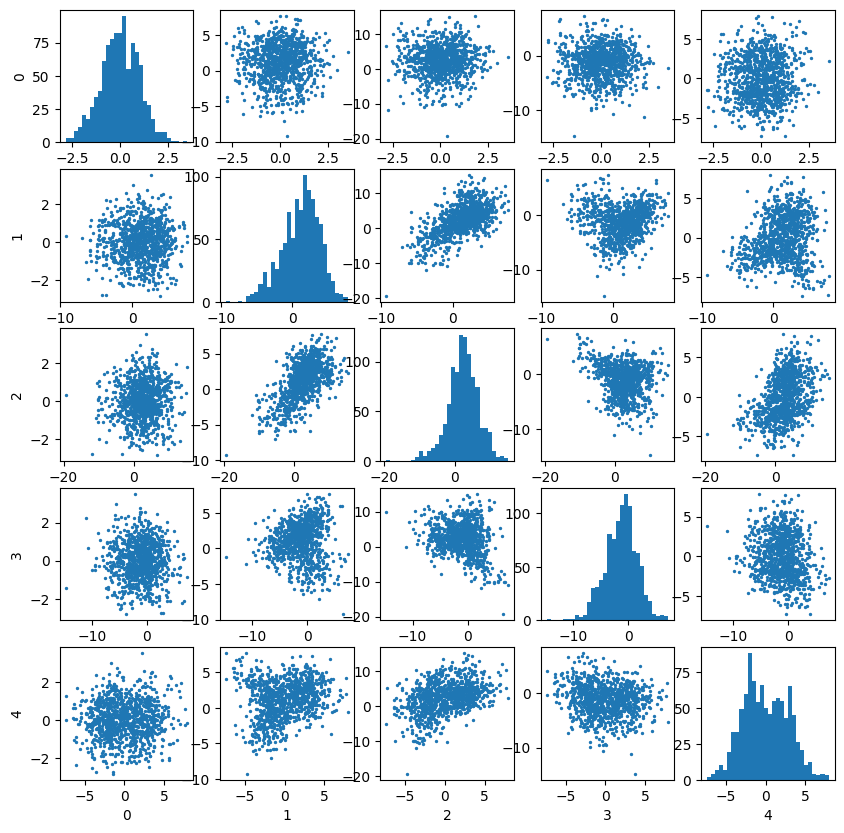

In [161]:
# First, let's just look at the relationship between pairs of features (since flat screens are good at visualizing 2 dimensions at a time).
# This is a kind of very simple dimensionality reduction in which we pick two dimensions to keep, and discard the rest.
import matplotlib.pyplot as plt
n_rows, n_cols = 5, 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10))
color = plt.cm.Set1(target)
for row in range(n_rows):
    ax[row, 0].set_ylabel(row)
    for col in range(n_cols):
        ax[-1, col].set_xlabel(col)
        if row == col:
            ax[row, col].hist(data[:, row], bins=30)
        else:
            ax[row, col].scatter(data[:, row], data[:, col], s=2,
                # color=color,
            )
        # ax.set_xscale('log')
        # ax.set_yscale('log')


So there is apparently some structure in the data when looking at 2 dimensions at a time.

But maybe we could see more structure if we were able to combine more than 2 dimensions at a time? 

Here we'll use scikit-learn to do a principal component analysis (PCA) to determine such an optimal combination of features:

In [162]:
from sklearn.decomposition import PCA

In [167]:
# Scikit-learn follows the same pattern here that we used for supervised learning:

# Create a model instance
pca = PCA(n_components=2)

# Fit the model to our data
pca.fit(data)

# Transform the data
pca_reduced = pca.transform(data)

# The result has 1000 rows just like the input data, but now only 2 features per row.
pca_reduced.shape

(1000, 2)

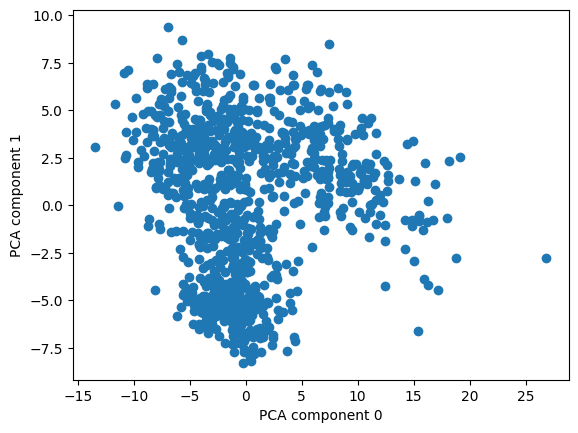

In [175]:
fig, ax = plt.subplots()
ax.scatter(pca_reduced[:, 0], pca_reduced[:, 1], 
    # color=color
)
ax.set_xlabel('PCA component 0')
ax.set_ylabel('PCA component 1');

Scilit-learn has many models that provide different approaches to dimensionality reduction. 

A more powerful (and much less interpretable) method is UMAP, which is actually not included in sklearn, but nonetheless implements a compatible API following the same pattern:

In [176]:
from umap import UMAP

# Create a model instance
umap = UMAP(
    n_components=2,
    n_neighbors=50,
    min_dist=0.4,
)

# Fit the model to data
umap.fit(data)

# Transform the data
umap_reduced = umap.transform(data)
umap_reduced.shape

(1000, 2)

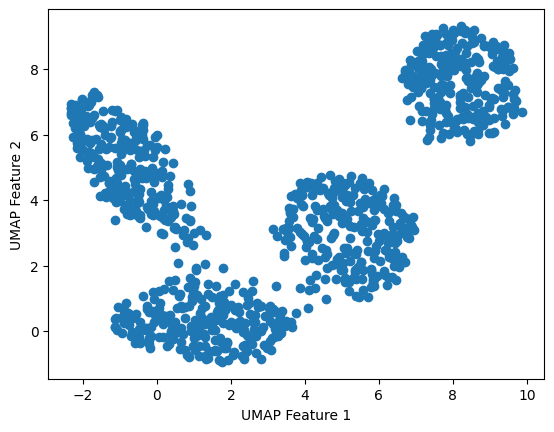

In [185]:
fig, ax = plt.subplots()
ax.scatter(umap_reduced[:, 0], umap_reduced[:, 1], 
    # color=color
)
ax.set_xlabel('UMAP Feature 1')
ax.set_ylabel('UMAP Feature 2');

At this point it looks clear that there is an even simpler way to describe our dataset:

Rather than each neuron being represented as a 2D vector, we could instead assign each a single integer for one of the 4 apparent clusters.

To do this, we use another unsupervised learning method called clustering.

In [181]:
from sklearn.cluster import KMeans

# Create a model instance
kmeans = KMeans(n_clusters=4, random_state=42)

# fit the model to our UMAP result
kmeans.fit(umap_reduced)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=42)

#### Visualize the Clustering 

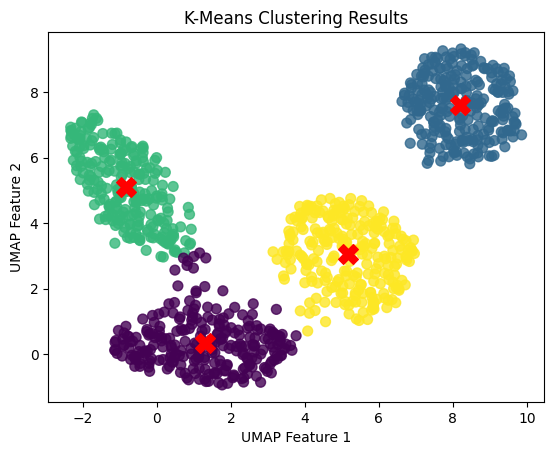

In [182]:
# Coordinates of cluster centers
centers = kmeans.cluster_centers_

# Cluster assignments for each data point
labels = kmeans.labels_

# Plot clusters
plt.scatter(umap_reduced[:, 0], umap_reduced[:, 1], c=labels, s=50, cmap='viridis', alpha=0.8)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X')
plt.title("K-Means Clustering Results")
plt.xlabel("UMAP Feature 1")
plt.ylabel("UMAP Feature 2")
plt.show()

In [5]:
### Evaluating the Performance of the Model

In [6]:
new_data = np.array([[0.2, 0.8], [0.6, 0.2]])
predicted_labels = kmeans.predict(new_data)
print("Predicted labels for new data:", predicted_labels)

Predicted labels for new data: [2 0]


#### What are the Shortcomings of this Model?

### Activity: Let's Try A Different Model

Choose something from https://scikit-learn.org/stable/unsupervised_learning.html